

```
4) Книги в магазинах.
а) Предсказать цену по остальным характеристикам, игнорируя магазины.
Диагностировать модель, при необходимости трансформировать предикторы. Использовать lasso регрессию, чтобы снизить размерность модели.
б) Удастся ли улучшить модель добавлением предикторов по магазинам (см. задачу про продукты).
в) Осмыслена ли непараметрическая модель, в которой вы заранее отобрали небольшое число наиболее важных предикторов?
```



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sb

from scipy import stats
import statsmodels.stats
import scipy

sb.set()

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["image.cmap"] = "viridis"

DPI_VALUE = 200

In [ ]:
!gdown --id 1sC3FkqslaBsj1CQTNPBlfZwfkhms_fTC
#загружаем файл xlsx с гугл таблиц

Downloading...
From: https://drive.google.com/uc?id=1sC3FkqslaBsj1CQTNPBlfZwfkhms_fTC
To: /content/Книжный АД :D.xlsx
100% 49.8k/49.8k [00:00<00:00, 36.2MB/s]


In [ ]:
#main_df = pd.read_csv('/home/data/Книжный АД D.xlsx - Лист1.csv')
xl = pd.ExcelFile('/content/Книжный АД :D.xlsx')
#main_df1 = xl.parse('Лист1')нахрен убрать
main_df = xl.parse('Лист2') 
#main_df.head()
#читаем сдесь xlsx файл

In [ ]:
main_df.shape

(180, 13)

In [ ]:
main_df.head(4)

,категория книг,название,Магазин,цена,количество страниц,визуальная привлекательность (1 - 5),качество обложки (1 - 5),качество переплёта (1 - 5),качество бумаги (1 - 5),качество печати (1 - 5),формат книги (0-3),размер книги (0-3),эксперт
0,популярные бестселлеры,как ты умрёшь,Читай-город,579.0,350.0,3.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0
1,популярные бестселлеры,девы,Читай-город,579.0,348.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,1.0
2,популярные бестселлеры,Гарри Поттер принц полукровка,Читай-город,1064.0,687.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,1.0
3,популярные бестселлеры,тысяча сияющих солнц,Читай-город,852.0,415.0,4.0,5.0,3.0,4.0,5.0,1.0,1.0,1.0


In [ ]:
reg_cols = ['категория книг',
            'количество страниц',
            'визуальная привлекательность (1 - 5)',
            'качество обложки (1 - 5)',
            'качество переплёта (1 - 5)',
            'качество бумаги (1 - 5)',
            'качество печати (1 - 5)',
            'формат книги (0-3)',
            'размер книги (0-3)']

In [ ]:
reg_df = np.array(main_df[reg_cols])

reg_df[reg_df == 'популярные бестселлеры'] = 1.
reg_df[reg_df == 'научно-популярная литература'] = 2.
reg_df[reg_df == 'классика'] = 3.

reg_data = reg_df.astype('float16')

reg_data[:, -2:] += 1.

price_col = np.array(main_df['цена'])

#split dataset to validation and train part
perm = np.array([ 80, 136, 134, 137,   9, 149, 160,  83, 110, 105,  58, 148,  87,
        97,  64, 161, 127, 170, 108, 145, 151, 147,  82,  42,   1, 175,
         6,   0,  23,  90, 103, 168, 169, 165,  12, 104, 115,  62,  56,
       116, 144,  51,  57, 146,  47, 132,  84,  18,  50, 153, 166,  95,
       179, 177, 126, 164, 125,  74, 139, 138, 150, 100, 141,  38, 106,
         8,  75,  39,  34,   5,  89,  11,  36,  10,  70,  28,  48, 128,
        19, 113, 107,  27,  49,  21,  41, 117,  25,  20,  63, 172,  96,
        61,  91, 152,  98,  53, 171,  86,  55,  66,   4, 120, 130, 178,
        43, 143,  17,  71, 112, 121,  44, 135,   7,  24, 114, 129,  46,
         2,  73,  13, 101,  76,  29, 176,  99,  40, 155, 133,  31,  88,
        92,  32, 119,  85,  26,  14,  22, 159,  94,  35, 163,  59,  79,
        69,  45,  65, 109,  78, 111,  16,  54,  30, 118, 142,  67,  72,
       123, 174,  52, 157, 102, 131, 156,  37, 167,   3, 154,  33,  77,
        68, 158, 162,  60, 124, 140, 122,  93,  15,  81, 173])

reg_data = reg_data[perm]
price_col = price_col[perm]

In [ ]:
indices = [i for i in range(144) if i not in []]

reg_data_train = reg_data[:144]
reg_data_val   = reg_data[144:]

price_train = price_col[:144]
price_val   = price_col[144:]

reg_data_train = reg_data_train[indices]
price_train = price_train[indices]

In [ ]:
model = Lasso(alpha=0.5)

Liner = model.fit(reg_data_train, price_train)

a = Liner.coef_
b = Liner.intercept_

price_pred = reg_data_val @ a + b

In [ ]:
Liner.coef_, Liner.intercept_

(array([  0.72939328, -30.83110633, 274.48263246, 335.29759535]),
 -1257.5441982575467)

In [ ]:
(abs(price_pred - price_val)).mean()

412.1841486883893

In [ ]:
(abs(770 - price_val)).mean()

420.3888888888889

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [ ]:
X = pd.DataFrame(reg_data)
y = pd.DataFrame(price_col)

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

In [ ]:
def get_standartized_residuals(residuals, Xw):
    Xw = np.array(Xw)
    XTX_inverse = np.linalg.inv(Xw.T @ Xw)

    H = Xw @ XTX_inverse @ (Xw.T)
    h = np.diag(H)
    
    result = residuals/np.sqrt((residuals**2).sum()/(len(residuals) - 2 - 1)) / np.sqrt(1 - h)
    
    return result

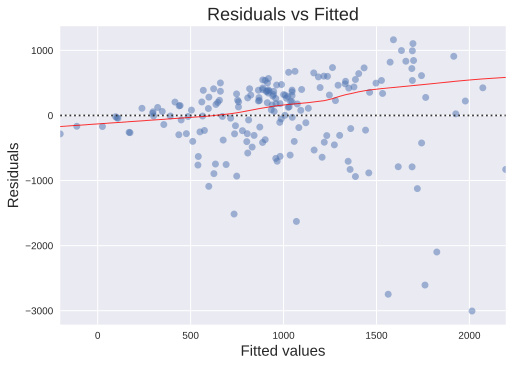

In [ ]:
# model values
model_fitted_y = reg_data @ a + b
# model residuals
model_residuals = model_fitted_y - price_col
# normalized residuals
model_norm_residuals = get_standartized_residuals(model_residuals, sm.add_constant(X))
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)


plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

plt.savefig('res_vs_fitted.png', dpi=DPI_VALUE)

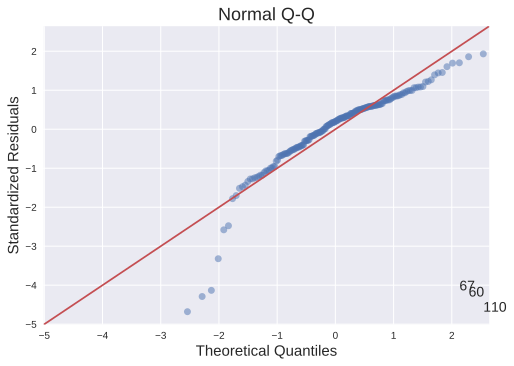

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));
plt.savefig('qq_plot.png', dpi=DPI_VALUE)

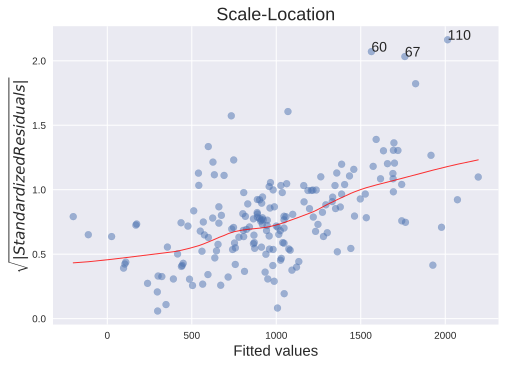

In [ ]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));
plt.savefig('scale_location.png', dpi=DPI_VALUE)

<h1>COEFS OF LASSO ACCORDING TO LAMBDA</h1>

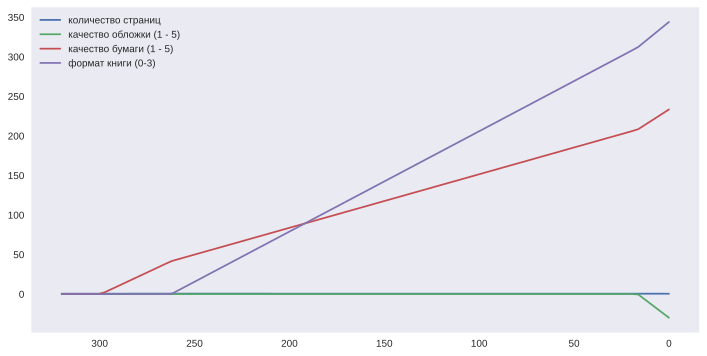

In [ ]:
alpha_lst = np.linspace(0.001, 320, 100)

alpha_y = list()

X = reg_data
Y = price_col

plt.figure(figsize=(12, 6))

for alpha in alpha_lst:
    clf = Lasso(alpha=alpha)

    Liner = clf.fit(X, Y)

    a = np.array(Liner.coef_)
    b = Liner.intercept_
    Y_new = np.matmul(X, a) + b
    
    alpha_y.append(list(Liner.coef_))
alpha_y = np.array(alpha_y).T
for i, arr in enumerate(alpha_y):
    plt.plot(alpha_lst, arr, label=f"{reg_cols[i]}")
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
plt.savefig('price_lambdas.png', dpi=DPI_VALUE)

No handles with labels found to put in legend.


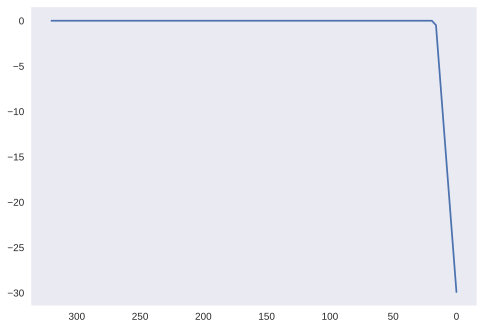

In [ ]:
plt.plot(alpha_lst, alpha_y[1])
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
plt.savefig('price_lambdas1.png', dpi=DPI_VALUE)

<h1>BOX COX</h1>

In [ ]:
X_ = np.array(reg_data_train)
X_[:, 1] = X_[:, 1] / X_.mean()
Y_ = np.array(price_train)
Y_ = Y_/Y_.mean()

In [ ]:
def get_fitted(x, y):
    X = pd.DataFrame(x)
    Y = pd.DataFrame(y)

    # generate OLS model
    model = sm.OLS(Y, sm.add_constant(X))
    model_fit = model.fit()
    
    model_fitted_y = model_fit.fittedvalues
    
    return model_fitted_y

In [ ]:
Y_.prod()

3.090446144702284e-15

In [ ]:
(Y_/Y_.mean() + 0.2).prod()

52.65112710171412

In [ ]:
def func(lmbds):
    X = np.zeros(X_.shape)
    for i, x in enumerate(X_.T):
      X[:, i] = stats.boxcox(x, lmbds[i])
      
    num = 1
    for n in Y_:
        num *= n
    num = num**(1/len(Y_))
    y = num**(1-lmbds[-1])*stats.boxcox(Y_, lmbds[-1])
    
    fitted = get_fitted(X, y)
    
    return ((fitted - y)**2).sum()/len(fitted)

In [ ]:
lmbds = scipy.optimize.minimize(func, 0.2*np.ones(len(X_[0]) + 1))

In [ ]:
lmbds.x

array([ 0.43732499,  0.2       ,  0.09844474,  0.2       , -0.26312894])

In [ ]:
X = np.zeros(X_.shape)
for i, x in enumerate(X_.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

num = 1
for n in Y_:
    num *= n
num = num**(1/len(Y_))
    
y = num**(1-lmbds['x'][-1])*stats.boxcox(Y_, lmbds['x'][-1])

In [ ]:
X = pd.DataFrame(X)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

X = pd.DataFrame(reg_data)
Y = pd.DataFrame(price_col)
# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [ ]:
# model values
model_fitted_y = model_fit.predict(sm.add_constant(X))
# model residuals
model_residuals = model_fitted_y - price_col
# normalized residuals
model_norm_residuals = get_standartized_residuals(model_residuals, sm.add_constant(X))
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

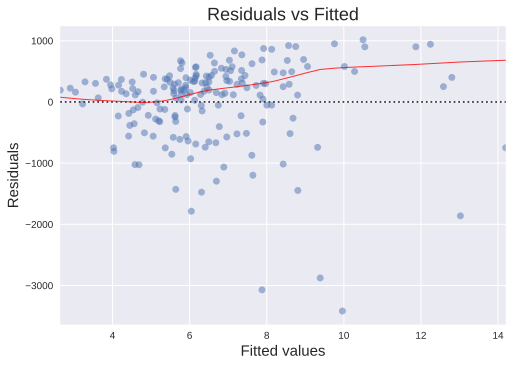

In [ ]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

plt.savefig('res_vs_fitted_boxcox.png', dpi=DPI_VALUE)

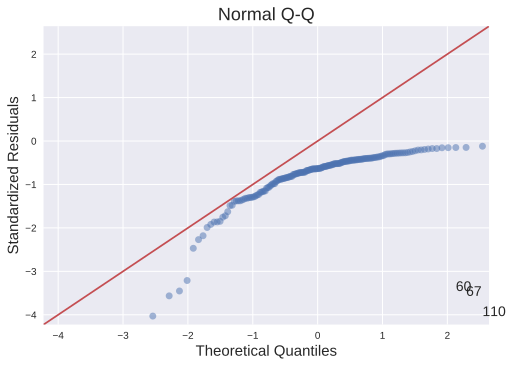

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));
plt.savefig('qq_plot_boxcox.png', dpi=DPI_VALUE)

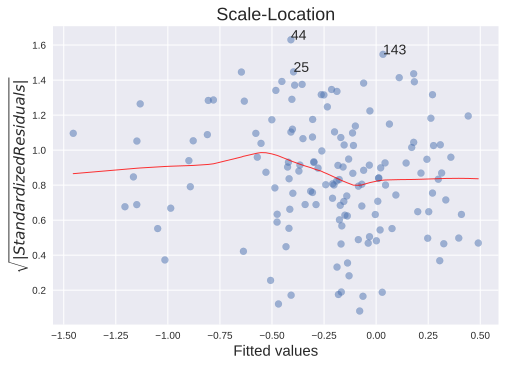

In [ ]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));
plt.savefig('scale_location_boxcox.png', dpi=DPI_VALUE)

<h1>NORM</h1>


In [ ]:
ri = model_fitted_y.values - Y[0].values
stats.jarque_bera(ri)

(3.653687102956118, 0.16092070489913102)

In [ ]:
stats.shapiro(ri)

(0.9800320267677307, 0.03377112001180649)

<h1>CHECK FOR HETERO</h1>

In [ ]:
statsmodels.stats.diagnostic.het_breuschpagan(model_fit.resid, model_fit.model.exog)

(13.677774735505102,
 0.1342579249712368,
 1.5626411218107774,
 0.13272694613611274)

<h1>CORRELATION OF RESIDUALS</h1>

In [ ]:
statsmodels.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=12)

(7.930438414634285, 0.7905424901959602, 0.5925360745101896, 0.8447899918758269)

In [ ]:
model_fit.params

const   -1.881466
0       -0.011717
1        0.074659
2       -0.126623
3        0.034179
4        0.027719
5        0.437120
6        0.316802
7        0.347530
8        0.122046
dtype: float64

In [ ]:
reg_cols[5:8], reg_cols[1]

(['качество бумаги (1 - 5)', 'качество печати (1 - 5)', 'формат книги (0-3)'],
 'количество страниц')

In [ ]:
def inverse_price(y):
  num = 1
  for n in Y_:
      num *= n
  num = num**(1/len(Y_))

  res = scipy.special.inv_boxcox(y/(num**(1-lmbds.x[-1])), lmbds.x[-1])

  return res * price_train.mean()

<h1>PREDICTIONS</h1>

In [ ]:
inverse_price(np.array(model_fitted_y[:5]))

array([959.93149068, 672.20818678, 684.72274871, 209.24296468,
       785.16152406])

In [ ]:
inverse_price(Y[0].values[:5])

array([650., 524., 473., 148., 376.])

In [ ]:
price_train[:5]

array([650., 524., 473., 148., 376.])

In [ ]:
check_data = np.array(reg_data_val)
check_data[:, 1] /= reg_data_train.mean()

X = np.zeros(check_data.shape)
for i, x in enumerate(check_data.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

model_fitted_y_val = model_fit.predict(sm.add_constant(X))

In [ ]:
price_preds = inverse_price(np.array(model_fitted_y_val))
price_preds

array([ 476.25511075,  593.02577488,  852.90181169,  547.86308902,
        401.71387759,  893.38748183, 1143.80509974,  587.35763046,
        858.80223128,  962.59089247, 1239.55788617, 1444.90828214,
        331.44826311, 1495.40708823,  743.38790574,  765.25128601,
        446.62447809,  749.13593986,  853.92278471,  564.94284425,
       1029.36183952,  866.40071553,  744.92346732, 1129.67934708,
       1106.64741364,  572.44333258, 1639.70780845, 1131.02566796,
        180.57615085,  405.67535304,  563.44411345,  767.91880041,
        565.44643288,  869.74056068, 1247.75027964,  637.57593634])

In [ ]:
abs(price_preds - price_val).mean()

339.28801242012804

<h1>WITH SHOPS</h1>

In [ ]:
data = np.array(main_df['Магазин'])

data[data == 'Читай-город'] = 1
data[data == 'Книжный лабиринт'] = 2
data[data == 'Молодая гвардия'] = 3

shop_cols = data[perm]

In [ ]:
binary_shop_cols = np.ones((len(reg_data), 3))

for i, col in enumerate(shop_cols):
  binary_shop_cols[i, int(col - 1)] = 2

In [ ]:
reg_data = np.concatenate((reg_data, binary_shop_cols), axis=1)

In [ ]:
reg_data = np.delete(reg_data, 1, axis=1)

In [ ]:
indices = [i for i in range(144) if i not in []]

reg_data_train = reg_data[:144]
reg_data_val   = reg_data[144:]

price_train = price_col[:144]
price_val   = price_col[144:]

reg_data_train = reg_data_train[indices]
price_train = price_train[indices]

In [ ]:
model = Lasso(alpha=0.3)

Liner = model.fit(reg_data_train, price_train)

a = Liner.coef_
b = Liner.intercept_

price_pred = reg_data_val @ a + b

In [ ]:
list(Liner.coef_), Liner.intercept_

([107.96611170971654,
  2.2676723373353282,
  24.98695347649538,
  -95.32311149475646,
  180.45381734657656,
  81.99701941254858,
  214.18883640871226,
  179.6541073451113,
  -45.802291839450085,
  888.7026091008225,
  -0.0],
 -1968.0930638984423)

In [ ]:
(abs(price_pred - price_val)).mean()

290.0874047080663

In [ ]:
X = pd.DataFrame(reg_data)
y = pd.DataFrame(price_col)

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

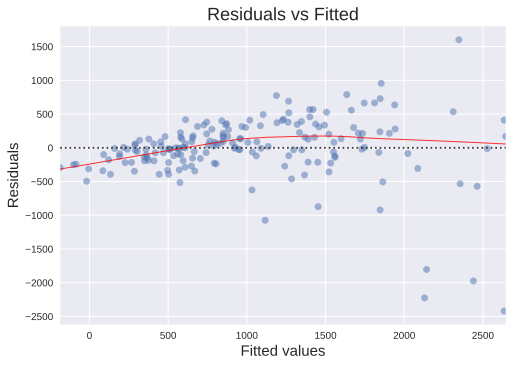

In [ ]:
# model values
model_fitted_y = reg_data @ a + b
# model residuals
model_residuals = model_fitted_y - price_col
# normalized residuals
model_norm_residuals = get_standartized_residuals(model_residuals, sm.add_constant(X))
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)


plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

plt.savefig('res_vs_fitted_with_shops.png', dpi=DPI_VALUE)

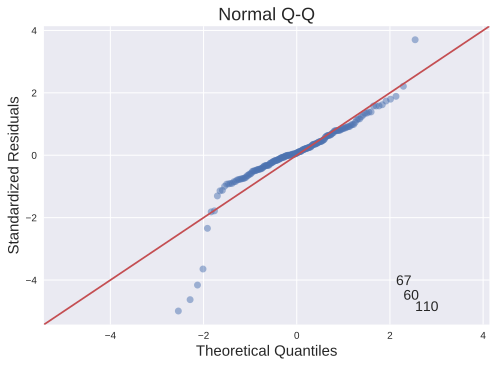

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));
plt.savefig('qq_plot_with_shops.png', dpi=DPI_VALUE)

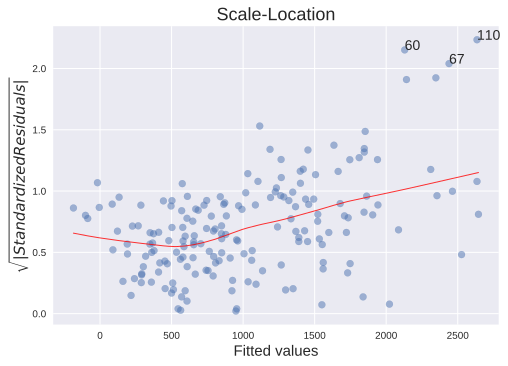

In [ ]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));
plt.savefig('scale_location_with_shops.png', dpi=DPI_VALUE)

<h1>COEFS OF LASSO ACCORDING TO LAMBDA</h1>

In [ ]:
new_reg_cols = ['категория книг',
                'количество страниц',
                'визуальная привлекательность (1 - 5)',
                'качество обложки (1 - 5)',
                'качество переплёта (1 - 5)',
                'качество бумаги (1 - 5)',
                'качество печати (1 - 5)',
                'формат книги (0-3)',
                'размер книги (0-3)',
                'Читай-город',
                'Книжный лабиринт',
                'Молодая гвардия']

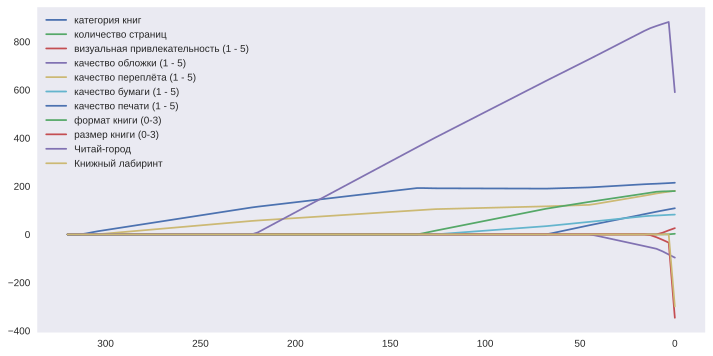

In [ ]:
alpha_lst = np.linspace(0.001, 320, 100)

alpha_y = list()

X = reg_data_train
Y = price_train

plt.figure(figsize=(12, 6))

for alpha in alpha_lst:
    clf = Lasso(alpha=alpha)

    Liner = clf.fit(X, Y)

    a = np.array(Liner.coef_)
    b = Liner.intercept_
    Y_new = np.matmul(X, a) + b
    
    alpha_y.append(list(Liner.coef_))
alpha_y = np.array(alpha_y).T
for i, arr in enumerate(alpha_y):
    plt.plot(alpha_lst, arr, label=f"{new_reg_cols[i]}")
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
plt.savefig('price_lambdas_with_shops.png', dpi=DPI_VALUE)

In [ ]:
reg_data.shape

(180, 11)

<h1>BOX COX</h1>

In [ ]:
X_ = np.array(reg_data_train)
X_[:, 1] = X_[:, 1] / X_.mean()
Y_ = np.array(price_train)
Y_ = Y_/Y_.mean()

In [ ]:
def get_fitted(x, y):
    X = pd.DataFrame(x)
    Y = pd.DataFrame(y)

    # generate OLS model
    model = sm.OLS(Y, sm.add_constant(X))
    model_fit = model.fit()
    
    model_fitted_y = model_fit.fittedvalues
    
    return model_fitted_y

In [ ]:
Y_.prod()

3.090446144702284e-15

In [ ]:
(Y_/Y_.mean() + 0.2).prod()

52.65112710171412

In [ ]:
def func(lmbds):
    X = np.zeros(X_.shape)
    for i, x in enumerate(X_.T):
      x
      X[:, i] = stats.boxcox(x, lmbds[i])
      
    num = 1
    for n in Y_:
        num *= n
    num = num**(1/len(Y_))
    y = num**(1-lmbds[-1])*stats.boxcox(Y_, lmbds[-1])
    
    fitted = get_fitted(X, y)
    
    return ((fitted - y)**2).sum()/len(fitted)

In [ ]:
lmbds = scipy.optimize.minimize(func, 0.0*np.ones(len(X_[0]) + 1))

In [ ]:
lmbds.x

array([ 3.32201021e+01,  1.54666202e+00,  1.82351575e+00,  3.96925691e+00,
        7.15820742e-01,  1.42826064e+01, -1.86319711e-02,  2.20250195e+00,
        2.48130625e-05,  2.19191005e-05,  1.95066836e-05, -1.68180327e-01])

In [ ]:
X = np.zeros(X_.shape)
for i, x in enumerate(X_.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

num = 1
for n in Y_:
    num *= n
num = num**(1/len(Y_))
    
y = num**(1-lmbds['x'][-1])*stats.boxcox(Y_, lmbds['x'][-1])

In [ ]:
X = pd.DataFrame(X)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [ ]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

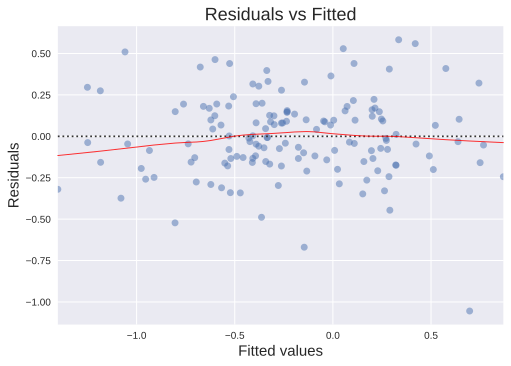

In [ ]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

plt.savefig('res_vs_fitted_boxcox_with_shops.png', dpi=DPI_VALUE)

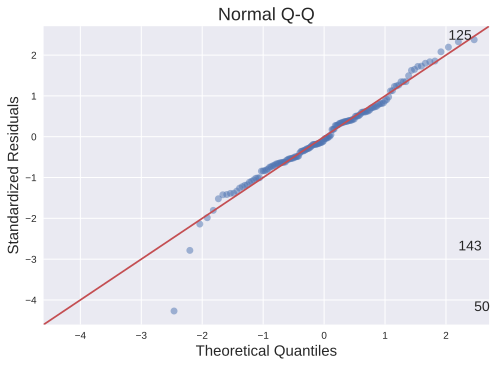

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));
plt.savefig('qq_plot_boxcox_with_shops.png', dpi=DPI_VALUE)

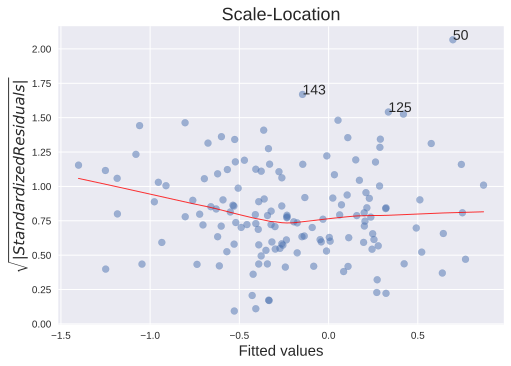

In [ ]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));
plt.savefig('scale_location_boxcox_with_shops.png', dpi=DPI_VALUE)

<h1>NORM</h1>


In [ ]:
ri = model_fitted_y.values - Y[0].values
stats.jarque_bera(ri)

(20.44775837177422, 3.62932354286416e-05)

In [ ]:
stats.shapiro(ri)

(0.9748157858848572, 0.009309325367212296)

<h1>CHECK FOR HETERO</h1>

In [ ]:
statsmodels.stats.diagnostic.het_breuschpagan(model_fit.resid, model_fit.model.exog)

(6.770305074318147, 0.8173679018987173, 0.83253772582524, 0.5754569256292958)

<h1>CORRELATION OF RESIDUALS</h1>

In [ ]:
statsmodels.stats.diagnostic.acorr_breusch_godfrey(model_fit, nlags=12)

(13.291259427598753,
 0.34823097121638064,
 1.1693899179811946,
 0.3110082224881931)

In [ ]:
def inverse_price(y):
  num = 1
  for n in Y_:
      num *= n
  num = num**(1/len(Y_))

  res = scipy.special.inv_boxcox(y/(num**(1-lmbds.x[-1])), lmbds.x[-1])

  return res * price_train.mean()

<h1>PREDICTIONS</h1>

In [ ]:
inverse_price(np.array(model_fitted_y[:5]))

array([844.29142798, 467.04508912, 544.99550061, 202.2013427 ,
       556.68566979])

In [ ]:
inverse_price(Y[0].values[:5])

array([650., 524., 473., 148., 376.])

In [ ]:
price_train[:5]

array([650., 524., 473., 148., 376.])

In [ ]:
check_data = np.array(reg_data_val)
check_data[:, 1] /= reg_data_train.mean()

X = np.zeros(check_data.shape)
for i, x in enumerate(check_data.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

model_fitted_y_val = model_fit.predict(sm.add_constant(X))

In [ ]:
price_preds = inverse_price(np.array(model_fitted_y_val))
price_preds

array([ 803.34335186,  451.91546309,  704.90535539,  481.70163739,
        439.22697405,  630.30809315, 2087.86203102, 1151.43554485,
        723.25153443,  760.44987301,  767.35713011,  923.06256873,
        364.31832977, 2305.84547298, 1176.30375678, 1263.33866042,
        424.49518896,  521.7304624 , 1480.17784921, 1024.59296311,
       1984.4646543 ,  663.80254062, 1176.98875186, 1888.99942506,
        638.40230623,  489.31888613, 2910.96138973, 1941.21152606,
        224.9808265 ,  386.17854046,  452.74309504,  558.13117741,
        477.26127381,  930.87778496,  859.80377979, 1249.67757735])

In [ ]:
abs(price_preds - price_val).mean()

242.32260755015943

In [ ]:
model_fit.params

const   -8.725840e-01
0       -5.830626e-16
1       -8.733132e-02
2        1.305316e-02
3       -3.904940e-04
4        2.412297e-01
5        8.987364e-11
6        2.503570e-01
7        3.803803e-02
8       -5.669194e-01
9        4.048851e-01
10      -4.427997e-01
dtype: float64

<h1>NON PARAMETRIC</h1>


In [ ]:
main_df.columns

Index(['категория книг', 'название', 'Магазин', 'цена', 'количество страниц',
       'визуальная привлекательность (1 - 5)', 'качество обложки (1 - 5)',
       'качество переплёта (1 - 5)', 'качество бумаги (1 - 5)',
       'качество печати (1 - 5)', 'формат книги (0-3)', 'размер книги (0-3)',
       'эксперт'],
      dtype='object')

In [ ]:
columns = ['Магазин', 'качество бумаги (1 - 5)', 'формат книги (0-3)', 'количество страниц']

reg_df = np.array(main_df[columns])

reg_df[reg_df == 'Читай-город'] = 1.
reg_df[reg_df == 'Книжный лабиринт'] = 2.
reg_df[reg_df== 'Молодая гвардия'] = 3.

reg_data = reg_df.astype('float32')

reg_data[:, -1] += 1.

price_col = np.array(main_df['цена'])

reg_data = reg_data[perm]
price_col = price_col[perm]

In [ ]:
shop_cols = reg_data[:, 0]

In [ ]:
reg_data.shape

(180, 4)

In [ ]:
binary_shop_cols = np.ones((len(reg_data), 3))

for i, col in enumerate(shop_cols):
  binary_shop_cols[i, int(col - 1)] = 2

In [ ]:
reg_data = np.concatenate((reg_data, binary_shop_cols), axis=1)

In [ ]:
reg_data = np.delete(reg_data, 0, axis=1)

In [ ]:
reg_data.shape

(180, 6)

In [ ]:
indices = [i for i in range(144) if i not in []]

reg_data_train = reg_data[:144]
reg_data_val   = reg_data[144:]

price_train = price_col[:144]
price_val   = price_col[144:]

reg_data_train = reg_data_train[indices]
price_train = price_train[indices]

In [ ]:
import statsmodels.nonparametric.kernel_regression

In [ ]:
X_ = reg_data_train
Y_ = price_train

In [ ]:
model_fit_l = statsmodels.nonparametric.kernel_regression.KernelReg(Y_, X_, 'cccccc', 'll')

In [ ]:
X = pd.DataFrame(X_)
y = pd.DataFrame(Y_)
dataframe = pd.concat([X, y], axis=1)

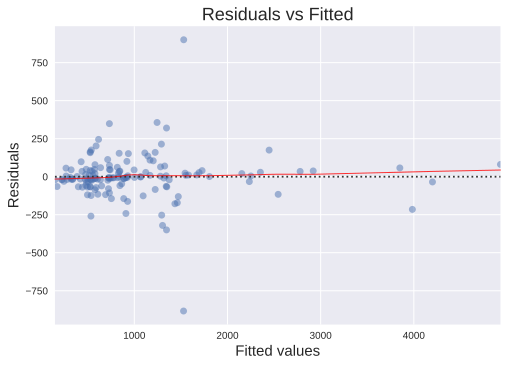

In [ ]:
# model values
model_fitted_y = model_fit_l.fit(X_)[0]
# model residuals
model_residuals = model_fitted_y - Y_
model_norm_residuals = get_standartized_residuals(model_residuals, sm.add_constant(X))
model_norm_residuals_abs_sqrt = np.sqrt(abs(model_norm_residuals))


plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plt.savefig('res_vs_fitted_non_parametric.png', dpi=DPI_VALUE)

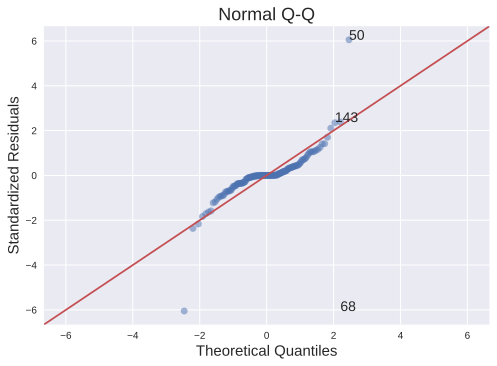

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));
plt.savefig('qq_plot_non_parametric.png', dpi=DPI_VALUE)

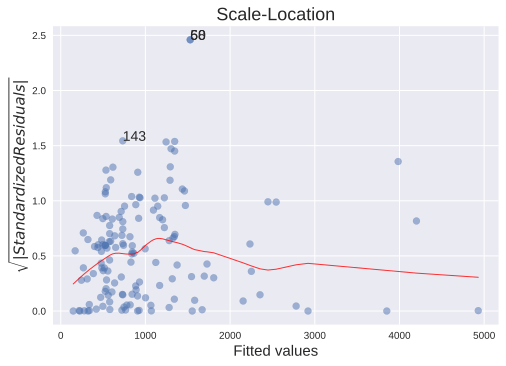

In [ ]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
  plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));
plt.savefig('scale_location_boxcox_with_shops.png', dpi=DPI_VALUE)

In [ ]:
(abs(model_fit_l.fit(reg_data_val)[0] - price_val)).mean()

289.290839621911

In [ ]:
(abs(model_fit_l.fit(reg_data_train)[0] - price_train)).mean()

80.58281709407014

<h1>SELECTION OF PREDICTORS</h1>

In [ ]:
reg_cols = ['количество страниц',
            'качество обложки (1 - 5)',
            'качество бумаги (1 - 5)',
            'формат книги (0-3)']

In [ ]:
reg_df = np.array(main_df[reg_cols])

reg_df[reg_df == 'популярные бестселлеры'] = 1.
reg_df[reg_df == 'научно-популярная литература'] = 2.
reg_df[reg_df == 'классика'] = 3.

reg_data = reg_df.astype('float32')

reg_data[:, -1:] += 1.

price_col = np.array(main_df['цена'])

#split dataset to validation and train part
perm = np.array([ 80, 136, 134, 137,   9, 149, 160,  83, 110, 105,  58, 148,  87,
        97,  64, 161, 127, 170, 108, 145, 151, 147,  82,  42,   1, 175,
         6,   0,  23,  90, 103, 168, 169, 165,  12, 104, 115,  62,  56,
       116, 144,  51,  57, 146,  47, 132,  84,  18,  50, 153, 166,  95,
       179, 177, 126, 164, 125,  74, 139, 138, 150, 100, 141,  38, 106,
         8,  75,  39,  34,   5,  89,  11,  36,  10,  70,  28,  48, 128,
        19, 113, 107,  27,  49,  21,  41, 117,  25,  20,  63, 172,  96,
        61,  91, 152,  98,  53, 171,  86,  55,  66,   4, 120, 130, 178,
        43, 143,  17,  71, 112, 121,  44, 135,   7,  24, 114, 129,  46,
         2,  73,  13, 101,  76,  29, 176,  99,  40, 155, 133,  31,  88,
        92,  32, 119,  85,  26,  14,  22, 159,  94,  35, 163,  59,  79,
        69,  45,  65, 109,  78, 111,  16,  54,  30, 118, 142,  67,  72,
       123, 174,  52, 157, 102, 131, 156,  37, 167,   3, 154,  33,  77,
        68, 158, 162,  60, 124, 140, 122,  93,  15,  81, 173])

reg_data = reg_data[perm]
price_col = price_col[perm]

In [ ]:
indices = [i for i in range(144) if i not in []]

reg_data_train = reg_data[:144]
reg_data_val   = reg_data[144:]

price_train = price_col[:144]
price_val   = price_col[144:]

reg_data_train = reg_data_train[indices]
price_train = price_train[indices]

In [ ]:
model = Lasso(alpha=0.5)

Liner = model.fit(reg_data_train, price_train)

a = Liner.coef_
b = Liner.intercept_

price_pred = reg_data_val @ a + b

In [ ]:
Liner.coef_, Liner.intercept_

(array([  0.72939336, -30.831097  , 274.48264   , 335.2976    ],
       dtype=float32), -983.0617)

In [ ]:
(abs(price_pred - price_val)).mean()

412.1841464572483

In [ ]:
X_ = np.array(reg_data_train)
X_[:, 1] = X_[:, 1] / X_.mean()
Y_ = np.array(price_train)
Y_ = Y_/Y_.mean()

In [ ]:
def get_fitted(x, y):
    X = pd.DataFrame(x)
    Y = pd.DataFrame(y)

    # generate OLS model
    model = sm.OLS(Y, sm.add_constant(X))
    model_fit = model.fit()
    
    model_fitted_y = model_fit.fittedvalues
    
    return model_fitted_y

In [ ]:
def func(lmbds):
    X = np.zeros(X_.shape)
    for i, x in enumerate(X_.T):
      X[:, i] = stats.boxcox(x, lmbds[i])
      
    num = 1
    for n in Y_:
        num *= n
    num = num**(1/len(Y_))
    y = num**(1-lmbds[-1])*stats.boxcox(Y_, lmbds[-1])
    
    fitted = get_fitted(X, y)
    
    return ((fitted - y)**2).sum()/len(fitted)

In [ ]:
lmbds = scipy.optimize.minimize(func, 0.*np.ones(len(X_[0]) + 1))
lmbds.x

array([ 0.3039793 , -0.0380735 ,  0.        ,  0.        , -0.28726967])

In [ ]:
X = np.zeros(X_.shape)
for i, x in enumerate(X_.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

num = 1
for n in Y_:
    num *= n
num = num**(1/len(Y_))
    
y = num**(1-lmbds['x'][-1])*stats.boxcox(Y_, lmbds['x'][-1])

In [ ]:
X = pd.DataFrame(X)
Y = pd.DataFrame(y)

# generate OLS model
model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, Y for easier plot handling
dataframe = pd.concat([X, Y], axis=1)

In [ ]:
def inverse_price(y):
  num = 1
  for n in Y_:
      num *= n
  num = num**(1/len(Y_))

  res = scipy.special.inv_boxcox(y/(num**(1-lmbds.x[-1])), lmbds.x[-1])

  return res * price_train.mean()

In [ ]:
check_data = np.array(reg_data_val)
check_data[:, 1] /= reg_data_train.mean()

X = np.zeros(check_data.shape)
for i, x in enumerate(check_data.T):
  X[:, i] = stats.boxcox(x, lmbds.x[i])

model_fitted_y_val = model_fit.predict(sm.add_constant(X))

In [ ]:
price_preds = inverse_price(np.array(model_fitted_y_val))
price_preds

array([ 557.19531137,  604.70479684,  831.53609527,  619.28023598,
        406.63213387,  743.15450794, 1022.48214664,  569.76168393,
        782.03625036, 1025.13109521, 1149.26532993, 1408.83551093,
        384.60365484,  978.3261046 ,  606.05168055,  705.73790173,
        416.17508962,  821.57662412,  861.98225079,  579.38830429,
        921.21477455,  799.86949071,  802.07254494, 1046.29787885,
       1095.00820131,  674.26841786, 1457.13821649,  971.23637372,
        183.53485923,  425.95411869,  544.93679973,  760.52862426,
        433.55498693, 1120.41680006, 1131.88623014,  571.75155388])

In [ ]:
abs(price_preds - price_val).mean()

378.6749104811999

<h1>SAVINGS</h1>

In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
!mv *.png images

In [ ]:
import shutil

shutil.make_archive('images', 'zip', 'images')

'/content/images.zip'